In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [0]:
import pandas as pd
scaled_data = pd.read_excel("min_max_scaled_data.xlsx")

In [0]:
import datetime as dt
hour_dummies = pd.get_dummies(pd.to_datetime(scaled_data['timestamp']).dt.hour)
scaled_data3 = pd.concat([scaled_data, hour_dummies], axis = 1).drop(columns = 'Unnamed: 0')

In [0]:
import holidays
date_tmp = pd.to_datetime(scaled_data3['timestamp'])
date_tmp2 = date_tmp.dt.strftime("%Y-%m-%d")

df_holidays = pd.DataFrame(holidays.UnitedStates(years=2016).keys())
holiday_dummy_list = [ 1 if i in list(pd.to_datetime(df_holidays[0])) else 0 for i in list(pd.to_datetime(date_tmp2))]

In [0]:
scaled_data3['holiday'] = pd.DataFrame({'holiday' : holiday_dummy_list})

In [10]:
scaled_data3.head()

,timestamp,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,weekend,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,holiday
0,2016-01-01 00:00:00,0.221033,0.297778,0.286420,0.007519,0.553633,0.233766,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2016-01-01 01:00:00,0.220558,0.260000,0.286420,0.007519,0.564014,0.266234,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 02:00:00,0.224972,0.246667,0.286420,0.007519,0.577855,0.201299,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2016-01-01 03:00:00,0.233563,0.222222,0.274074,0.007519,0.598616,0.201299,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 04:00:00,0.239860,0.211111,0.259259,0.007519,0.612457,0.201299,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
import calendar

In [0]:
tmp_date = scaled_data3.copy()
tmp_date['timestamp'] = pd.to_datetime(tmp_date['timestamp'])
tmp_date = tmp_date.rename(columns = {'timestamp' : 'weekday'})
tmp_date['weekday'] = pd.to_datetime(tmp_date['weekday'])

In [13]:
tmp_date['weekday']

0      2016-01-01 00:00:00
1      2016-01-01 01:00:00
2      2016-01-01 02:00:00
3      2016-01-01 03:00:00
4      2016-01-01 04:00:00
               ...        
8779   2016-12-31 19:00:00
8780   2016-12-31 20:00:00
8781   2016-12-31 21:00:00
8782   2016-12-31 22:00:00
8783   2016-12-31 23:00:00
Name: weekday, Length: 8784, dtype: datetime64[ns]

In [0]:
tmp_date= pd.DataFrame(tmp_date.set_index('weekday').index.weekday)

In [0]:
dum_day_of_week = pd.get_dummies(tmp_date['weekday'].apply(lambda x: calendar.day_name[x]))

In [20]:
dum_day_of_week.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [0]:
scaled_data4 = pd.concat([scaled_data3,dum_day_of_week], axis = 1)

In [0]:
scaled_data4.to_excel("scaled_data_with_dummies.xlsx")

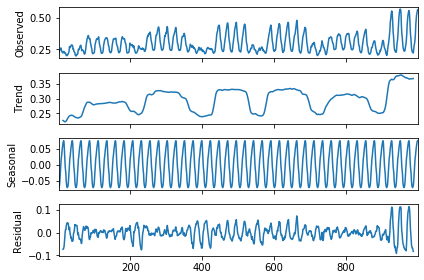

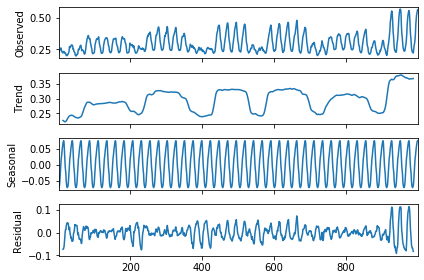

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(scaled_data4['meter_reading'][1:1000], model = 'additive',
                            freq = 24)

decomp.plot()

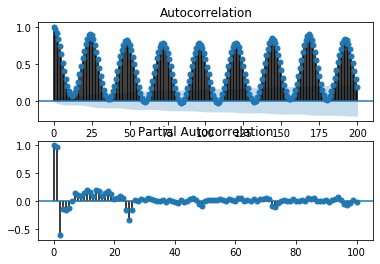

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,1)
plot_acf(scaled_data4['meter_reading'], lags=200, ax=axes[0])
plot_pacf(scaled_data4['meter_reading'], lags=100, ax=axes[1])
plt.show()

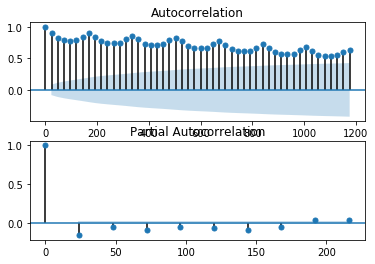

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,1)
plot_acf(scaled_data4['meter_reading'], lags=[24*x for x in range(50)], ax=axes[0])
plot_pacf(scaled_data4['meter_reading'], lags=[24*x for x in range(10)], ax=axes[1])
plt.show()

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(scaled_data4.iloc[:,1][:-720], exog=scaled_data4.drop(columns=['dew_temperature' ,'wind_speed']).iloc[:,2:][:-720], order=(1, 1, 0), seasonal_order=(0, 0, 0, 24))
res = model.fit()
res.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:          meter_reading   No. Observations:                 8064
Model:               SARIMAX(1, 1, 0)   Log Likelihood               17029.218
Date:                Sat, 23 Nov 2019   AIC                         -33982.437
Time:                        12:50:51   BIC                         -33716.625
Sample:                             0   HQIC                        -33891.490
                               - 8064                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
air_temperature        0.0385      0.017      2.267      0.023       0.005       0.072
precip_depth_1_hr     -0.0140      0.007     -2.066      0.039      -0.027      -0.001
sea_level_pressure     0.1721      0.029      5.852      0.000       0.114       0.230
weekend                0.0002      0.004      0.046      0.963      -0.007       0.007
0                     -0.1607      0.005    -35.253      0.000      -0.170      -0.152
1                     -0.1679      0.005    -37.206      0.000      -0.177      -0.159
2                     -0.1688      0.004    -41.486      0.000      -0.177      -0.161
3                     -0.1630      0.004    -41.326      0.000      -0.171      -0.155
4                     -0.1211      0.004    -31.921      0.000      -0.129      -0.114
5                     -0.0626      0.004    -16.887      0.000      -0.070      -0.055
6                     -0.0324      0.004     -8.917      0.000      -0.040      -0.025
7                     -0.0101      0.004     -2.809      0.005      -0.017      -0.003
8                      0.0237      0.004      6.426      0.000       0.016       0.031
9                      0.0685      0.004     17.967      0.000       0.061       0.076
10                     0.1025      0.004     25.588      0.000       0.095       0.110
11                     0.1252      0.004     30.405      0.000       0.117       0.133
12                     0.1400      0.004     33.732      0.000       0.132       0.148
13                     0.1523      0.004     36.634      0.000       0.144       0.160
14                     0.1582      0.004     36.581      0.000       0.150       0.167
15                     0.1561      0.004     37.048      0.000       0.148       0.164
16                     0.1363      0.004     32.044      0.000       0.128       0.145
17                     0.0940      0.004     20.995      0.000       0.085       0.103
18                     0.0235      0.005      5.103      0.000       0.014       0.033
19                    -0.0306      0.004     -6.906      0.000      -0.039      -0.022
20                    -0.0599      0.004    -14.178      0.000      -0.068      -0.052
21                    -0.0866      0.004    -20.386      0.000      -0.095      -0.078
22                    -0.1310      0.004    -29.275      0.000      -0.140      -0.122
23                    -0.1520      0.004    -33.932      0.000      -0.161      -0.143
holiday               -0.0099      0.012     -0.849      0.396      -0.033       0.013
Friday                -0.0005      0.007     -0.075      0.940      -0.014       0.013
Monday                -0.0017      0.005     -0.316      0.752      -0.012       0.009
Saturday               0.0006      0.005      0.133      0.894      -0.008       0.010
Sunday                -0.0012      0.004     -0.298      0.766      -0.009       0.007
Thursday              -0.0017      0.006     -0.267      0.789      -0.014       0.011
Tuesday            -1.

In [0]:
import matplotlib.pyplot as plt

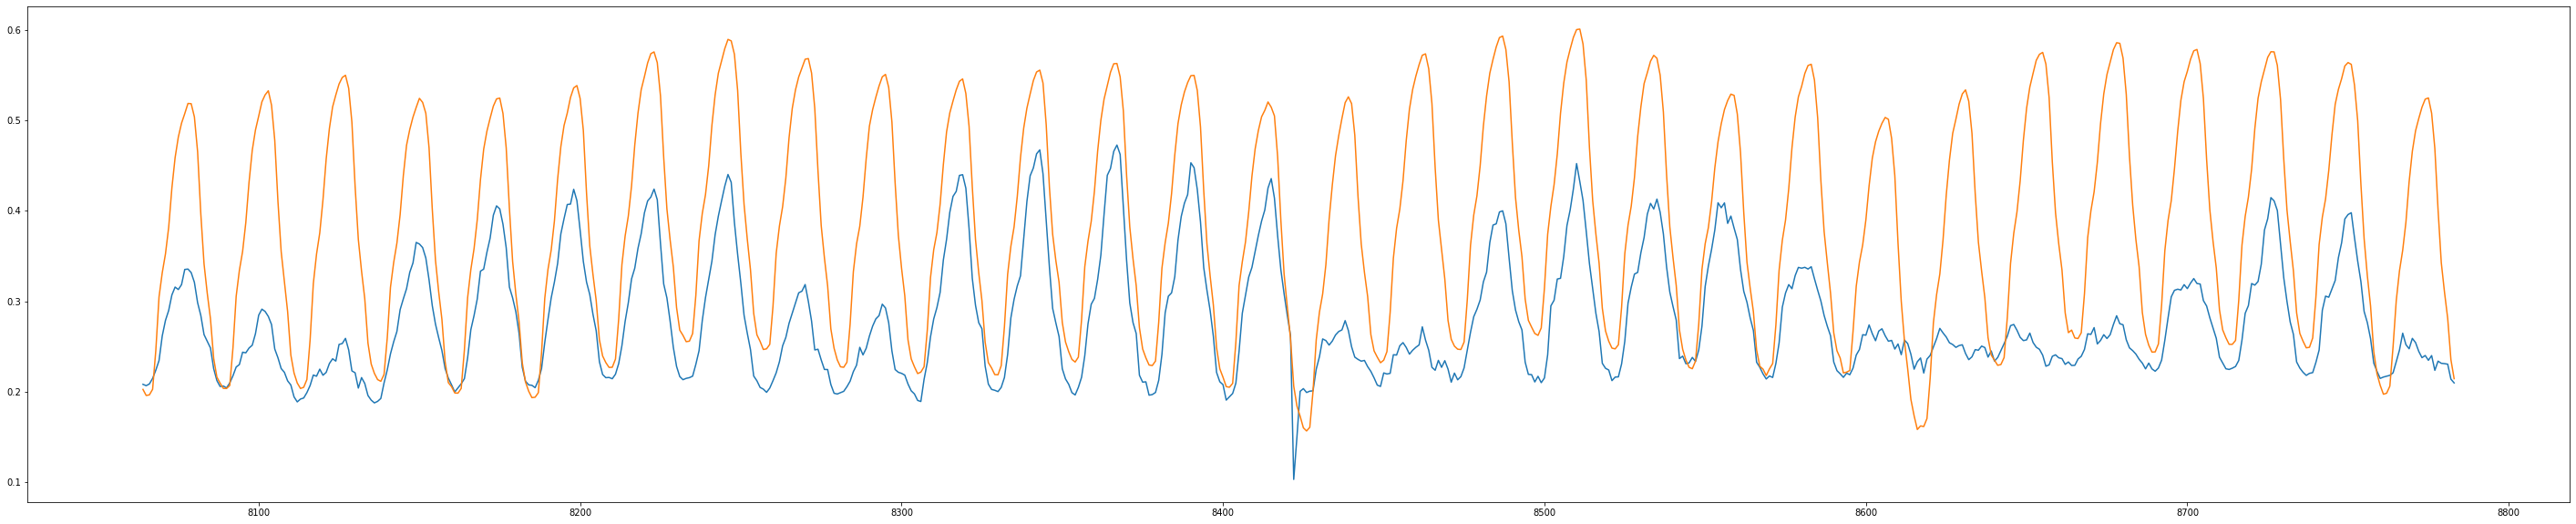

In [31]:
plt.figure(figsize=(50,10))
plt.plot(scaled_data4['meter_reading'][-720:])
plt.plot(pred)

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
for p in range(6):
    for q in range(6):
        for d in range(4):
            for P in range(6) :
                for D in range(4):
                    for Q in range(6) :
                        try:
        # Create and fit ARMA(p,q) model
                              model = SARIMAX(scaled_data3.iloc[:,1][:-720],
                                    exog = scaled_data3.drop(columns=['dew_temperature' ,'wind_speed']).iloc[:,2:][:-720],
                                    order=(p,d,q),
                                    seasonal_order=(P, D, Q, 24),
                                    trend='c')
                              
                              results = model.fit()
        
        # Print p, q, AIC, BIC
                              order_aic_bic.append((p,d,q,P,D,Q,results.aic,results.bic))
                      
                        except:
                              print(p,d,q, P, D, Q, None, None)